In [1]:
!mkdir -p /scratch/sagarsj42/torch-cache
!mkdir -p /scratch/sagarsj42/transformers
!mkdir -p /scratch/sagarsj42/hf-datasets

import os
os.chdir('/scratch/sagarsj42')
os.environ['TORCH_HOME'] = '/scratch/sagarsj42/torch-cache'
os.environ['TRANSFORMERS_CACHE'] = '/scratch/sagarsj42/transformers'
os.environ['HF_DATASETS_CACHE'] = '/scratch/sagarsj42/hf-datasets'

In [2]:
import random
import string
import copy

import datasets
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import transformers
from transformers import BertTokenizer, BertModel

2021-12-11 01:53:44.723310: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-11 01:53:44.723352: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
transformers.logging.set_verbosity_error()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [4]:
# Copied from explore_wikiqa.ipynb
def get_valid_questions(wikiqa):
    question_status = dict()

    for split in wikiqa:
        split_dataset = wikiqa[split]
        n_samples = len(split_dataset)

        for i in range(n_samples):
            qid = split_dataset[i]['question_id']
            label = split_dataset[i]['label']
            if qid not in question_status:
                question_status[qid] = label
            else:
                question_status[qid] = max(question_status[qid], label)

    valid_questions = set([qid for qid in question_status if question_status[qid] > 0])
    
    return valid_questions

In [5]:
class AS2Dataset(Dataset):
    def __init__(self, as2, name, tokenizer, max_length):
        super(AS2Dataset, self).__init__()
        self.as2 = as2
        self.name = name
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        if name == 'wikiqa':
            self.sentence_key = 'answer'
        else:
            self.sentence_key = 'sentence'
        
    def __len__(self):
        return len(self.as2)
    
    def __getitem__(self, idx):
        sample = self.as2[idx]
        question = sample['question'].translate(
            str.maketrans('', '', string.punctuation)).lower().strip()
        sentence = sample[self.sentence_key].translate(
            str.maketrans('', '', string.punctuation)).lower().strip()
        label = sample['label'] * 1.0
        
        input_enc = tokenizer(text=question, text_pair=sentence, 
                              add_special_tokens=True, truncation=True, padding='max_length', 
                              max_length=self.max_length, 
                              return_tensors='pt', return_attention_mask=True)
        
        if self.name == 'wikiqa':
            return (sample['question_id'], question, sentence, 
                    input_enc['input_ids'].flatten(), input_enc['attention_mask'].flatten(), 
                    input_enc['token_type_ids'].flatten(), 
                    label)
        else:
            return (question, sentence, input_enc['input_ids'].flatten(), 
                    input_enc['attention_mask'].flatten(), input_enc['token_type_ids'].flatten(), 
                    label)

In [6]:
class TandaTransfer(nn.Module):
    def __init__(self, encoder):
        super(TandaTransfer, self).__init__()
        self.encoder = encoder
        self.layers = nn.Sequential(
            nn.Linear(768, 1),
            nn.Dropout(p=0.25)
        )
        
    def forward(self, x):
        a = x[1]
        x = self.encoder(input_ids=x[0], attention_mask=x[1], token_type_ids=x[2]).last_hidden_state
        x = (x * a.unsqueeze(-1) / a.sum(1).view(-1, 1, 1)).sum(1)
        x = self.layers(x)
        
        return x

In [7]:
# Copied from bert_finetuning.ipynb
class BertQA(nn.Module):
    def __init__(self, encoder):
        super(BertQA, self).__init__()
        self.encoder = encoder
        self.layers = nn.Sequential(
            nn.Linear(768, 512),
            nn.Dropout(p=0.25),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(512, 1),
            nn.Dropout(p=0.15),
        )
        
    def forward(self, x):
        a = x[1]
        x = self.encoder(input_ids=x[0], attention_mask=x[1], token_type_ids=x[2]).last_hidden_state
        x = (x * a.unsqueeze(-1) / a.sum(1).view(-1, 1, 1)).sum(1)
        x = self.layers(x)
        
        return x

In [8]:
# asnq = datasets.load_dataset('asnq')
# asnq

In [9]:
# asnq_f = asnq.filter(lambda sample: 
#                      sample['sentence_in_long_answer'] or sample['short_answer_in_sentence'])
# asnq_f.save_to_disk('asnq-2-3')
# asnq_f

In [10]:
asnq_f = datasets.load_from_disk('asnq-2-3')
asnq_f

DatasetDict({
    train: Dataset({
        features: ['question', 'sentence', 'label', 'sentence_in_long_answer', 'short_answer_in_sentence'],
        num_rows: 931448
    })
    validation: Dataset({
        features: ['question', 'sentence', 'label', 'sentence_in_long_answer', 'short_answer_in_sentence'],
        num_rows: 59658
    })
})

In [11]:
train_indices = random.sample(range(len(asnq_f['train'])), 10000)
dev_indices = random.sample(range(len(asnq_f['validation'])), 400)

asnq_ff = dict()
asnq_ff['train'] = asnq_f['train'].select(train_indices)
asnq_ff['validation'] = asnq_f['validation'].select(dev_indices)
asnq_f = asnq_ff
asnq_f

{'train': Dataset({
     features: ['question', 'sentence', 'label', 'sentence_in_long_answer', 'short_answer_in_sentence'],
     num_rows: 10000
 }),
 'validation': Dataset({
     features: ['question', 'sentence', 'label', 'sentence_in_long_answer', 'short_answer_in_sentence'],
     num_rows: 400
 })}

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encoder = BertModel.from_pretrained('bert-base-uncased')
encoder

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [13]:
tok_lengths = list()

for sample in asnq_f['train']:
    question = sample['question']
    sentence = sample['sentence']
    tok_len = min(256, len(tokenizer(text=question, text_pair=sentence)['input_ids']))
    tok_lengths.append(tok_len)
    
len(tok_lengths)

10000

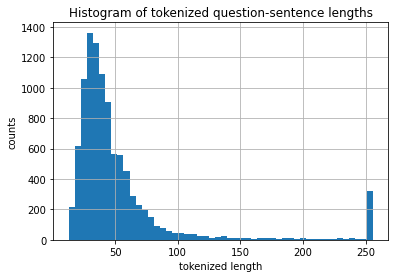

In [14]:
plt.hist(tok_lengths, density=False, bins=50)
plt.xlabel('tokenized length')
plt.ylabel('counts')
plt.title('Histogram of tokenized question-sentence lengths')
plt.grid()
plt.show()

In [16]:
batch_size = 16
transfer_epochs = 2
transfer_learning_rate = 1e-6

criterion = nn.BCEWithLogitsLoss()
criterion

BCEWithLogitsLoss()

In [34]:
def train_epochs_asnq(n_epochs, dataloader, model, optimizer, criterion, 
                      dev_dataloader=None, eval_steps=10000, save_path='./best.pth', device='cpu'):
    model.train()
    n_batches = len(dataloader)
    best_loss = float('inf')
    
    for epoch in range(n_epochs):
        total_loss = 0.0
        for step, sample in enumerate(dataloader):
            sample = sample[2:6]
            sample = [s.to(device) for s in sample]
            optimizer.zero_grad()
            output = model(sample[:-1])
            loss = criterion(output.flatten(), sample[-1].flatten())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            if step > 0 and step % eval_steps == 0:
                dev_loss = validate_asnq(dev_dataloader, model, criterion, device=device)
                if dev_loss < best_loss:
                    best_loss = dev_loss
                    save_dict = {
                        'epoch': epoch+1,
                        'step': step,
                        'dev_loss': dev_loss,
                        'model_params': model.state_dict()
                    }
                    torch.save(save_dict, save_path)
                    print(f'Best checkpoint saved at epoch {epoch+1}, step {step}, dev loss: {dev_loss:.4f}')
                step_loss = 0.0
        
        save_dict = {
                    'epoch': epoch,
                    'step': step,
                    'dev_loss': dev_loss,
                    'model_params': model.state_dict()
                    }
        torch.save(save_dict, 'final-transfer.pth')
        total_loss /= n_batches
        print(f'Epoch {epoch+1} complete. Train loss: {total_loss:.4f}')
    
    return total_loss

def validate_asnq(dataloader, model, criterion, device='cpu'):
    model.eval()
    n_batches = len(dataloader)
    total_loss = 0.0
    
    for sample in dataloader:
        sample = sample[2:6]
        sample = [s.to(device) for s in sample]
        output = model(sample[:-1])
        loss = criterion(output.flatten(), sample[-1].flatten())
        total_loss += loss.item()
        
    return total_loss / n_batches

In [18]:
asnq_train_ds = AS2Dataset(asnq_f['train'], 'asnq', tokenizer, max_length=128)
asnq_dev_ds = AS2Dataset(asnq_f['validation'], 'asnq', tokenizer, max_length=128)

len(asnq_train_ds), len(asnq_dev_ds)

(10000, 400)

In [19]:
asnq_train_dl = DataLoader(asnq_train_ds, batch_size=batch_size, shuffle=True)
asnq_dev_dl = DataLoader(asnq_dev_ds, batch_size=batch_size, shuffle=False)

len(asnq_train_dl), len(asnq_dev_dl)

(625, 25)

In [20]:
model = TandaTransfer(encoder)
model.to(DEVICE)
model = nn.DataParallel(model)

optimizer = Adam(model.parameters(), lr=transfer_learning_rate)

In [21]:
train_loss = train_epochs_asnq(transfer_epochs, asnq_train_dl, model, optimizer, criterion, 
                               dev_dataloader=asnq_dev_dl, eval_steps=100, save_path='best-transfer.pth', 
                               device=DEVICE)
train_loss

Best checkpoint saved at epoch 1, step 100, dev loss: 0.3479
Best checkpoint saved at epoch 1, step 200, dev loss: 0.2534
Best checkpoint saved at epoch 1, step 300, dev loss: 0.2443
Best checkpoint saved at epoch 1, step 400, dev loss: 0.2429
Best checkpoint saved at epoch 1, step 500, dev loss: 0.2408
Epoch 1 complete. Train loss: 0.2842
Best checkpoint saved at epoch 2, step 100, dev loss: 0.2393
Best checkpoint saved at epoch 2, step 200, dev loss: 0.2380
Best checkpoint saved at epoch 2, step 300, dev loss: 0.2377
Best checkpoint saved at epoch 2, step 400, dev loss: 0.2374
Best checkpoint saved at epoch 2, step 500, dev loss: 0.2321
Best checkpoint saved at epoch 2, step 600, dev loss: 0.2315
Epoch 2 complete. Train loss: 0.2191


0.21906690506860613

In [22]:
model = TandaTransfer(encoder)
save_dict = torch.load('best-transfer.pth')
model.load_state_dict(save_dict['model_params'], strict=False)
model

TandaTransfer(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [23]:
wikiqa = datasets.load_dataset('wiki_qa')
valid_questions = get_valid_questions(wikiqa)
wikiqa_f = wikiqa.filter(lambda sample: sample['question_id'] in valid_questions)

wikiqa_f

Using custom data configuration default
Reusing dataset wiki_qa (/scratch/sagarsj42/hf-datasets/wiki_qa/default/0.1.0/d2d236b5cbdc6fbdab45d168b4d678a002e06ddea3525733a24558150585951c)


  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/21 [00:00<?, ?ba/s]

DatasetDict({
    test: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 2351
    })
    validation: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 1130
    })
    train: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 8672
    })
})

In [24]:
adapt_learning_rate = 5e-6
adapt_epochs = 5

criterion = nn.BCEWithLogitsLoss()
criterion

BCEWithLogitsLoss()

In [25]:
model = BertQA(model.encoder)
model.to(DEVICE)

optimizer = Adam(model.parameters(), lr=adapt_learning_rate, betas=(0.9, 0.999), eps=1e-7)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-07
    lr: 5e-06
    weight_decay: 0
)

In [26]:
wikiqa_train_ds = AS2Dataset(wikiqa_f['train'], 'wikiqa', tokenizer, max_length=64)
wikiqa_dev_ds = AS2Dataset(wikiqa_f['validation'], 'wikiqa', tokenizer, max_length=64)
wikiqa_test_ds = AS2Dataset(wikiqa_f['test'], 'wikiqa', tokenizer, max_length=64)

len(wikiqa_train_ds), len(wikiqa_dev_ds), len(wikiqa_test_ds)

(8672, 1130, 2351)

In [27]:
wikiqa_train_dl = DataLoader(wikiqa_train_ds, batch_size=batch_size, shuffle=True)
wikiqa_dev_dl = DataLoader(wikiqa_dev_ds, batch_size=batch_size, shuffle=False)
wikiqa_test_dl = DataLoader(wikiqa_test_ds, batch_size=batch_size, shuffle=False)

len(wikiqa_train_dl), len(wikiqa_dev_dl), len(wikiqa_test_dl)

(542, 71, 147)

In [28]:
# Copied from bert_finetuning.ipynb

def train_epoch(dataloader, model, optimizer, criterion, device='cpu'):
    model.train()
    n_batches = len(dataloader)
    total_loss = 0.0
    
    for sample in dataloader:
        sample = sample[3:7]
        sample = [s.to(device) for s in sample]
        optimizer.zero_grad()
        output = model(sample[:-1])
        loss = criterion(output.flatten(), sample[-1].flatten())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    return total_loss / n_batches

def validate(dataloader, model, criterion, device='cpu'):
    model.eval()
    n_batches = len(dataloader)
    total_loss = 0.0
    
    for sample in dataloader:
        sample = sample[3:7]
        sample = [s.to(device) for s in sample]
        output = model(sample[:-1])
        loss = criterion(output.flatten(), sample[-1].flatten())
        total_loss += loss.item()
        
    return total_loss / n_batches

def get_scores(dataloader, model, device='cpu'):
    model.eval()
    eval_results = list()
    
    for batch in dataloader:
        batch_d = [b.to(device) for b in batch[3:6]]
        output = model(batch_d).detach()
        scores = nn.Sigmoid()(output)
        
        batch[-1] = batch[-1].tolist()
        batch.append(scores.flatten().tolist())
        size = len(batch[0])
        eval_results.extend([[b[i] for b in batch] for i in range(size)])
        
    return eval_results

def get_question_label_scores(results):
    q_dict = dict()
    
    for result in results:
        qid = result[0]
        if qid in q_dict:
            q_dict[qid][1].append(result[2])
            q_dict[qid][2].append(result[6])
            q_dict[qid][3].append(result[7])
        else:
            q_dict[qid] = [result[1], [result[2]], [result[6]], [result[7]]]
            
    return q_dict

def calculate_metrics(question_scores):
    total = len(question_scores) * 1.0
    thresholds = np.arange(10, 20) / 20
    accuracy = 0
    mrr = 0.0
    mean_ap = dict()
    
    for qid, values in question_scores.items():
        labels = values[2]
        scores = values[3]
        actual = np.array(labels).argmax()
        predicted = np.array(scores).argmax()
        expected_max = scores[actual]
        scores.sort(reverse=True)
        given_rank = scores.index(expected_max) + 1
        
        for t in thresholds:
            tp = np.sum(scores[actual] > t)
            tp_fp = np.sum(np.array(scores) > t)
            p = 1.0 if tp_fp == 0 else tp/tp_fp
            if t in mean_ap:
                mean_ap[t] += p / total
            else:
                mean_ap[t] = 0.0
        
        if actual == predicted:
            accuracy += 1
        mrr += (1.0/given_rank)
        
    accuracy /= total
    mean_ap = np.array(list(mean_ap.values())).mean()
    mrr /= total
    
    return accuracy, mean_ap, mrr

def plot_curves(train_stats, dev_stats, index, title):
    n_epochs = len(train_stats)+1
    plt.plot(range(1, n_epochs), [s[index] for s in train_stats])
    plt.plot(range(1, n_epochs), [s[index] for s in dev_stats])
    plt.xlabel('Epochs')
    plt.ylabel(title)
    plt.title(f'Comparison of {title} variation over epochs')
    plt.legend(['train', 'dev'])
    plt.grid()
    plt.show()

In [29]:
best_mrr = float('-inf')
best_model = None
train_stats = list()
dev_stats = list()

for epoch in range(adapt_epochs):
    train_loss = train_epoch(wikiqa_train_dl, model, optimizer, criterion, device=DEVICE)
    dev_loss = validate(wikiqa_dev_dl, model, criterion, device=DEVICE)
    
    train_results = get_scores(wikiqa_train_dl, model, device=DEVICE)
    train_qscores = get_question_label_scores(train_results)
    train_acc, train_map, train_mrr = calculate_metrics(train_qscores)
    train_stats.append((train_loss, train_acc, train_map, train_mrr))
    
    dev_results = get_scores(wikiqa_dev_dl, model, device=DEVICE)
    dev_qscores = get_question_label_scores(dev_results)
    dev_acc, dev_map, dev_mrr = calculate_metrics(dev_qscores)
    dev_stats.append((dev_loss, dev_acc, dev_map, dev_mrr))
    
    if dev_mrr > best_mrr:
        best_mrr = dev_mrr
        best_model = copy.deepcopy(model)
    
    print(f'Epoch {epoch+1} complete. Train loss: {train_loss:.4f}, Dev loss: {dev_loss:.4f}')
    print(f'Accuracy: train = {train_acc}, dev = {dev_acc}')
    print(f'MAP: train = {train_map}, dev = {dev_map}')
    print(f'MRR: train = {train_mrr}, dev = {dev_mrr}')
    print('-'*80)
    
save_dict = {'model_params': best_model.state_dict(), 
             'train_stats': train_stats, 
             'dev_stats': dev_stats
            }
torch.save(save_dict, 'best-wikiqa-adapt.pth')

Epoch 1 complete. Train loss: 0.3744, Dev loss: 0.2793
Accuracy: train = 0.5601374570446735, dev = 0.6349206349206349
MAP: train = 0.9412180221458541, dev = 0.9722222222222197
MRR: train = 0.7191778306197731, dev = 0.7418839758125473
--------------------------------------------------------------------------------
Epoch 2 complete. Train loss: 0.3173, Dev loss: 0.2653
Accuracy: train = 0.6471935853379153, dev = 0.6349206349206349
MAP: train = 0.8625525009545599, dev = 0.9519841269841244
MRR: train = 0.7818224222004289, dev = 0.7566452506928697
--------------------------------------------------------------------------------
Epoch 3 complete. Train loss: 0.2858, Dev loss: 0.2676
Accuracy: train = 0.715922107674685, dev = 0.6507936507936508
MAP: train = 0.7102539137075197, dev = 0.8894179894179871
MRR: train = 0.8312269027904767, dev = 0.7734822716965575
--------------------------------------------------------------------------------
Epoch 4 complete. Train loss: 0.2586, Dev loss: 0.2855
A

In [30]:
save_dict = torch.load('best-wikiqa-adapt.pth')
train_stats = save_dict['train_stats']
dev_stats = save_dict['dev_stats']
save_dict.keys()

dict_keys(['model_params', 'train_stats', 'dev_stats'])

In [31]:
model = BertQA(encoder)
model.load_state_dict(save_dict['model_params'])
model.to(DEVICE)

BertQA(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [35]:
test_loss = validate(wikiqa_test_dl, model, criterion, device=DEVICE)
test_loss

0.26922729940548573

In [37]:
test_results = get_scores(wikiqa_test_dl, model, device=DEVICE)
test_qscores = get_question_label_scores(test_results)
test_acc, test_map, test_mrr = calculate_metrics(test_qscores)

print(f'Test data: Accuracy = {test_acc}, MAP = {test_map}, MRR = {test_mrr}')

Test data: Accuracy = 0.5967078189300411, MAP = 0.8528395061728371, MRR = 0.7468191616339763


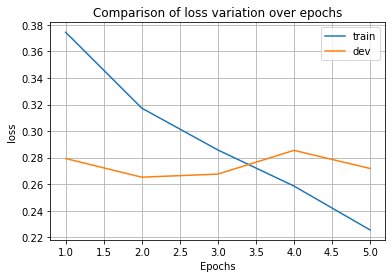

In [38]:
plot_curves(train_stats, dev_stats, 0, 'loss')

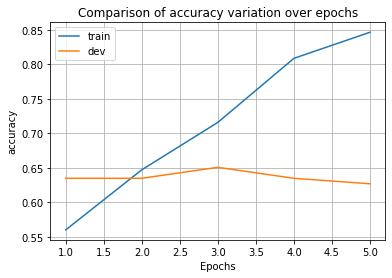

In [39]:
plot_curves(train_stats, dev_stats, 1, 'accuracy')

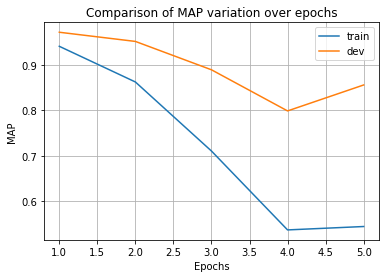

In [40]:
plot_curves(train_stats, dev_stats, 2, 'MAP')

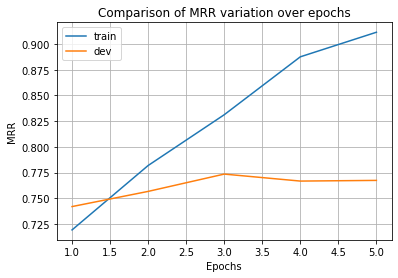

In [41]:
plot_curves(train_stats, dev_stats, 3, 'MRR')